# (test code) In-context data-driven control methods


# System examples
1. Linear scalar unstable system
1. Linear 2-D unstable system 
1. Nonlinear 2-D unstable system

# Data-driven control methods 
1. LQR
1. DMD-control (Proctor, Brunton, Kutz)
1. MPC


In [3]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 
                     'xtick.major.size': 6, 'xtick.major.width': 2, 
                     'ytick.major.size': 6, 'ytick.major.width': 2}
                    )
# same updates global for plotly: font size, xtick and ytick size, and axes lw
px.defaults.template = "plotly_dark" 
import control as ct

### Linear scalar stable system

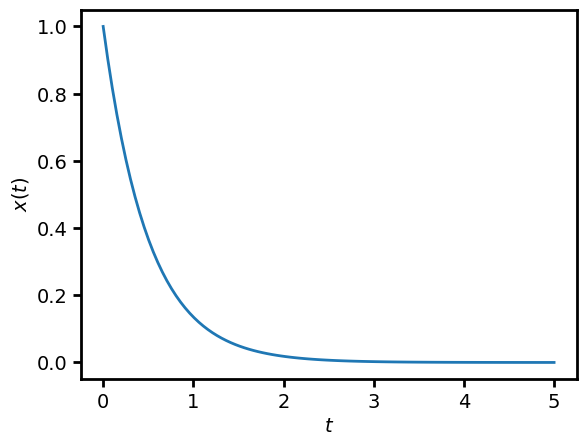

In [4]:
a = 2
t = np.linspace(0, 5, 100)
x0 = 1
sys_lss = ct.ss(-a, 0, 1, 0)
t, y_gt_lss = ct.initial_response(sys_lss, t, x0)
plt.plot(t, y_gt_lss, lw=2)
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.show()


### Linear scalar unstable system (with stabilizing control)

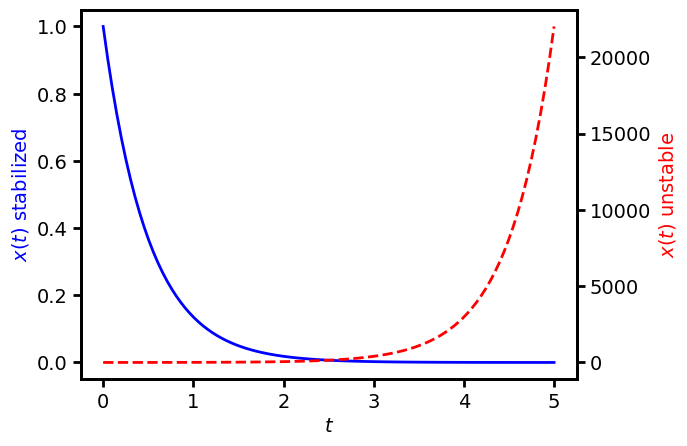

In [5]:
a = 2
sys_lsu = ct.ss(a, 1, 1, 0)
t, y_gt_lsu = ct.initial_response(sys_lsu, t, x0)
# Now control it
k = 4
fdbk_sys = ct.feedback(sys_lsu, k)
t, y_gt_lsus = ct.initial_response(fdbk_sys, t, x0)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, y_gt_lsus, lw=2, c='b')
ax2.plot(t, y_gt_lsu, lw=2, ls='--', c='r')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x(t)$ stabilized', c='blue')
ax2.set_ylabel('$x(t)$ unstable', c='r')
plt.show()


In [6]:
# Data driven control instead of state feedbcak control
# sysd_est, y_gt_lsu
sysd_est, _ = ct.eigensys_realization(y_gt_lsus, r=1)

In [7]:
sysd_est

StateSpace(array([[0.9039239]]), array([[-0.95074913]]), array([[-0.95074913]]), array([[1.]]), True)

In [8]:
fdbk_sys

StateSpace(array([[-2.]]), array([[1.]]), array([[1.]]), array([[0.]]))

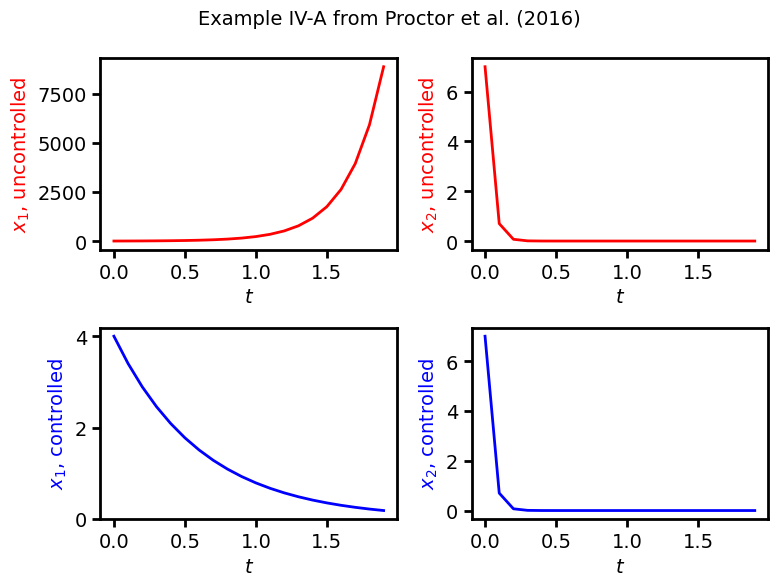

In [299]:
# DMD-control
A = np.array([[1.5, 0], [0, 0.1]])
B = np.array([[1], [0]])
C = np.array([[1, 0], [0, 1]])
D = 0
sys_2d = ct.ss(A, B, C, D, dt=0.1)
x0 = [4, 7]
t = np.arange(0, 2, 0.1)
t, y_gt_2d = ct.initial_response(sys_2d, t, x0)
K = np.array([[0.65], [0]]).T
sys_2d_fdbk = ct.ss(A-B@K, [0,0], C, D, dt=0.1)
t, y_gt_2d_fdbk = ct.initial_response(sys_2d_fdbk, t, x0)
fig, ax = plt.subplots(2,2, figsize=(8, 6))
ax[0,0].plot(t, y_gt_2d[0,], lw=2, c='r')
ax[0,1].plot(t, y_gt_2d[1,], lw=2, c='r')
ax[0,0].set_ylabel('$x_1$, uncontrolled', c='r')
ax[0,0].set_xlabel('$t$')
ax[0,1].set_xlabel('$t$')
ax[0,1].set_ylabel('$x_2$, uncontrolled', c='r')
ax[1,0].plot(t, y_gt_2d_fdbk[0,], lw=2, c='b')
ax[1,1].plot(t, y_gt_2d_fdbk[1,], lw=2, c='b')
ax[1,0].set_ylabel('$x_1$, controlled', c='b')
ax[1,0].set_xlabel('$t$')
ax[1,1].set_xlabel('$t$')
ax[1,1].set_ylabel('$x_2$, controlled', c='b')
fig.suptitle('Example IV-A from Proctor et al. (2016)', fontsize=14)
plt.tight_layout()
plt.show()

In [300]:
# All input values (ground truth)
u_gt = -K@y_gt_2d_fdbk

In [301]:
# context data X and X'
X = y_gt_2d_fdbk[:, :4]
X_prime = y_gt_2d_fdbk[:, 1:5]
# current control input
Gamma = u_gt[:, :4]

In [302]:
X

array([[4.    , 3.4   , 2.89  , 2.4565],
       [7.    , 0.7   , 0.07  , 0.007 ]])

In [303]:
X_prime

array([[3.400000e+00, 2.890000e+00, 2.456500e+00, 2.088025e+00],
       [7.000000e-01, 7.000000e-02, 7.000000e-03, 7.000000e-04]])

In [304]:
Gamma

array([[-2.6     , -2.21    , -1.8785  , -1.596725]])

In [258]:
U, S, Vh = np.linalg.svd(X, full_matrices=False)
Omega = np.vstack((X, Gamma))
U_tilde, S_tilde, Vh_tilde = np.linalg.svd(Omega, full_matrices=False)
U_hat, S_hat, Vh_hat = np.linalg.svd(X_prime, full_matrices=False)
S_inv = np.diag(1/S)
S_tilde_inv = np.diag(1/S_tilde)
# # S_hat_inv = np.diag(1/S_hat)
# # first n=2 rows of U_tilde and all columns is:
U_1_tilde = U_tilde.T[:, :2].T
U_2_tilde = U_tilde.T[:, 2:].T
A_approx = U_hat.T @ X_prime @ Vh_tilde.T @ S_tilde_inv @ U_1_tilde.T @ U_hat
# A_approx = X_prime @ Vh_tilde.T @ S_tilde_inv @ U_1_tilde.T
B_approx = U_hat.T @ X_prime @ Vh_tilde.T @ S_tilde_inv @ U_2_tilde.T
# B_approx = X_prime @ Vh_tilde.T @ S_tilde_inv @ U_2_tilde.T
# # A_approx = (X_prime - B@Gamma)@Vh.T@S_inv@U.T
A_approx_cl = (X_prime)@Vh.T@S_inv@U.T
latest_x = np.reshape(X_prime[:,-1], (2,1))
Bu_pred_prime = (A_approx_cl - A_approx)@latest_x
# # print("Bu predicted is", Bu_pred_prime)
# # print("Correct Bu is", B@Gamma[:,-1])
print("A estimated", A_approx)
print("A_approx_cl", A_approx_cl)
print("B estimated", B_approx)

A estimated [[ 0.52678093  0.12019606]
 [-0.25765757  0.02743485]]
A_approx_cl [[ 5.00000000e-01 -5.55111512e-17]
 [-2.08166817e-17  1.00000000e-01]]
B estimated [[-0.05836184]
 [ 0.37611627]]


In [161]:
G_tilde = X_prime @ Vh_tilde.T @ S_tilde_inv @ U_tilde.T

In [162]:
print(np.shape(G_tilde))
print(np.shape(U_1_tilde))
print(np.shape(U_2_tilde))
print(U_tilde.T.shape)

(2, 3)
(2, 3)
(1, 3)
(3, 3)


In [163]:
B_approx

array([[-0.17524988],
       [ 0.32746975]])

In [155]:
U_tilde_new = np.hstack((U_1_tilde.T, U_2_tilde.T)).T
np.allclose(U_tilde, U_tilde_new)

True

In [156]:
U_tilde.shape

(3, 3)

In [305]:
# Plot code
def plot_sys_response(figure_objects, t, y_gt, **kwargs):
    fig1, fig2 = figure_objects
    name = kwargs.get('name', 'x')
    color = kwargs.get('color', 'blue')
    # add scatter points on top of the lines with same color dots with black boundary within same trace
    fig1.add_trace(
        go.Scatter(
            x=t,
            y=y_gt[0,],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=2),
            marker=dict(
                color=color,
                line=dict(color="black", width=1),
                size=6
            )
        )
    )
    fig2.add_trace(
        go.Scatter(
            x=t,
            y=y_gt[1,],
            mode="lines+markers",
            name=name,
            line=dict(color=color, width=2),
            marker=dict(
                color=color,
                line=dict(color="black", width=1),
                size=6
            )
        )
    )
    return fig1, fig2

In [306]:
T

20

In [ ]:
T = len(t)
points = np.linspace(0.5, 1.0, T)
color_list = px.colors.sample_colorscale(px.colors.sequential.GnBu, points)
M_icl = T//2 # max number of in-context length
# M_icl = 5
m_p = T - M_icl # the size of prediction window
fig1 = go.Figure()
fig2 = go.Figure()

def compute_dmd_control_and_predict(X, X_prime, Gamma):
    U, S, Vh = np.linalg.svd(X, full_matrices=False)
    print(X)
    print(Gamma)
    Omega = np.vstack((X, Gamma))
    print(Omega)
    # U_tilde, S_tilde, Vh_tilde = np.linalg.svd(Omega, full_matrices=False)
    # U_hat, S_hat, Vh_hat = np.linalg.svd(X_prime, full_matrices=False)
    S_inv = np.diag(1/S)
    # S_tilde_inv = np.diag(1/S_tilde)
    # S_hat_inv = np.diag(1/S_hat)
    # first n=2 rows of U_tilde and all columns is:
    # U_1_tilde = U_tilde[:2, :]
    # U_2_tilde = U_tilde[2:, :]
    # A_approx = U_hat.T @ X_prime @ Vh_tilde.T @ S_tilde_inv @ U_1_tilde.T @ U_hat
    # B_approx = U_hat.T @ X_prime @ Vh.T @ S_inv @ U_2_tilde.T
    # A_approx = (X_prime - B@Gamma)@Vh.T@S_inv@U.T
    A_approx_cl = (X_prime)@Vh.T@S_inv@U.T
    # latest_x = np.reshape(X_prime[:,-1], (2,1))
    # Bu_pred_prime = (A_approx_cl - A_approx)@latest_x
    # print("Bu predicted is", Bu_pred_prime)
    # print("Correct Bu is", B@Gamma[:,-1])
    # print("A estimated", A_approx)
    # print("A_approx_cl", A_approx_cl)
    # print("")
    # return A_approx, A_approx_cl, latest_x, Bu_pred_prime
    return A_approx_cl

for i in range(M_icl):
    # context data X and X'
    X = y_gt_2d_fdbk[:, M_icl-i-1:M_icl]
    X_prime = y_gt_2d_fdbk[:, M_icl-i:M_icl+1]
    # if i == 0:
    #     print(X)
    #     print(X_prime)
    # current control input
    Gamma = u_gt[:, M_icl-i-1:M_icl]
    # A_approx, A_approx_cl, latest_x, Bu_pred_prime = compute_dmd_control_and_predict(X,X_prime, Gamma)
    A_approx_cl = compute_dmd_control_and_predict(X, X_prime, Gamma)
    # forward prediction
    for j in range(m_p):
        # generate y_predicted with latest x and latest control values predicted above
        # y_pred = A_approx@latest_x + np.reshape(Bu_pred_prime, (-1,1))
        cl_sys = ct.ss(A_approx_cl, [0,0], np.eye(2), 0, dt=0.1)
        prediction_timepoints = np.array([cl_sys.dt]) # only one step ahead
        starting_x = X_prime[:,-1].reshape(-1,1)
        t_sim, y_pred = ct.initial_response(cl_sys, prediction_timepoints, starting_x)
        X_prime = np.hstack((X_prime, y_pred[:,-1].reshape(-1,1)))
        X = np.hstack((X, X_prime[:,-1].reshape(-1,1)))
        Gamma = np.hstack((Gamma, Bu_pred_prime[0].reshape(-1,1)))
        # A_approx, A_approx_cl, latest_x, Bu_pred_prime = compute_dmd_control_and_predict(X, X_prime, Gamma)
        A_approx_cl = compute_dmd_control_and_predict(X, X_prime, Gamma)
        print(A_approx_cl)
    # plot
    color = color_list[i]
    # new_t has i number of time points before M_icl and the m_p points after M_icl
    new_t = np.hstack((t[M_icl-i-1:M_icl], t[M_icl:M_icl+m_p]))
    fig1, fig2 = plot_sys_response((fig1, fig2), new_t, X, name=f'n_icl={i+1}', color=color)
# Plot ground truth
fig1, fig2 = plot_sys_response((fig1, fig2), t, y_gt_2d_fdbk, name='Ground truth', color='red')
# plot a vertical line at t = wherever M_icl index is.
fig1.add_shape(
    dict(
        type="line",
        x0=t[M_icl-1],
        y0=0,
        x1=t[M_icl-1],
        y1=y_gt_2d_fdbk[0,].max(),
        line=dict(color="black", width=1, dash="dashdot")
    )
)
fig2.add_shape(
    dict(
        type="line",
        x0=t[M_icl-1],
        y0=0,
        x1=t[M_icl-1],
        y1=np.max(y_gt_2d_fdbk[1,]),
        line=dict(color="black", width=1, dash="dashdot")
    )
)
fig1.update_layout(title='DMD-control: x_1', xaxis_title='t', yaxis_title='$x_1$')
fig2.update_layout(title='DMD-control: x_2', xaxis_title='t', yaxis_title='$x_2$')
fig1.show()
fig2.show()

[[9.26467785e-01]
 [7.00000000e-09]]
[[7.87497617e-01]
 [7.00000000e-10]]
[[9.26467785e-01]
 [7.00000000e-09]]
[[-0.60220406]]
[[ 9.26467785e-01]
 [ 7.00000000e-09]
 [-6.02204060e-01]]
[[9.26467785e-01 6.69372975e-01]
 [7.00000000e-09 5.95000000e-10]]
[[-0.60220406]]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

In [279]:
y_pred[:,-1]

array([1.953125e-03, 3.500000e-10])

In [54]:
B@Gamma

array([[-2.6       , -2.21      , -1.8785    , -1.596725  , -1.35721625,
        -1.15363381, -0.98058874, -0.83350043, -0.70847537, -0.60220406,
         0.51187345,  0.9831235 ,  1.30637403,  0.82333258,  0.33651902,
         0.15455155,  0.08520785,  0.05343487,  0.03656589,  0.02660744],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [17]:
u_gt

array([[-2.6       , -2.21      , -1.8785    , -1.596725  , -1.35721625,
        -1.15363381, -0.98058874, -0.83350043, -0.70847537, -0.60220406,
        -0.51187345, -0.43509243, -0.36982857, -0.31435428, -0.26720114,
        -0.22712097, -0.19305282, -0.1640949 , -0.13948067, -0.11855857]])